In [ ]:
import nltk
print("Downloading required NLTK data...")
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

import pandas as pd
import numpy as np
from datetime import datetime
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Load Data

In [ ]:
import csv
df = pd.read_csv('complaints_filtered.csv', quoting=csv.QUOTE_MINIMAL, escapechar='\\', on_bad_lines='skip')


In [ ]:
df.dtypes

,0
Date received,object
Product,object
Sub-product,object
Issue,object
Sub-issue,object
Consumer complaint narrative,object
Company public response,object
Company,object
State,object
ZIP code,object


In [ ]:
print(df['Date received'].head())

0    05/02/23
1    08/14/24
2    10/12/23
3    04/04/24
4    08/07/14
Name: Date received, dtype: object


Field name| Description| Data type| Notes
----------|------------|---------|-------|
Date received| The date the CFPB received the complaint| date & time|
Product| The type of product the consumer identified in the complaint| plain text| This field is a categorical variable.
Sub-product| The type of sub-product the consumer identified in the complaint| plain text| This field is a categorical variable. Not all Products have Sub-products.
Issue| The issue the consumer identified in the complaint| plain text| This field is a categorical variable. Possible values are dependent on Product.
Sub-issue| The sub-issue the consumer identified in the complaint| plain text| This field is a categorical variable. Possible values are dependent on product and issue. Not all Issues have corresponding Sub-issues.
Consumer complaint narrative| Consumer complaint narrative is the consumer-submitted description of "what happened" from the complaint. Consumers must opt-in to share their narrative. We will not publish the narrative unless the consumer consents, and consumers can opt-out at any time. The CFPB takes reasonable steps to scrub personal information from each complaint that could be used to identify the consumer.| plain text| Consumers' descriptions of what happened are included if consumers consent to publishing the description and after we take steps to remove personal information."
Company public response| The company's optional, public-facing response to a consumer's complaint. Companies can choose to select a response from a pre-set list of options that will be posted on the public database. For example, "Company believes complaint is the result of an isolated error."| plain text| Companies' public-facing responses to complaints are included if companies choose to publish one. Companies may select a public response from a set list of options as soon as they respond to the complaint, but no later than 180 days after the complaint was sent to the company for response.
Company| The complaint is about this company| plain text| This field is a categorical variable.
State| The state of the mailing address provided by the consumer| plain text| This field is a categorical variable.
ZIP code| The mailing ZIP code provided by the consumer| plain text| The mailing ZIP code provided by the consumer. The 5-digit United States Postal Service ZIP code will be published where provided unless the consumer lived in a ZIP code aligned to a United States Census Bureau ZIP Code Tabulation Area (ZCTA) with fewer than 20,000 people and consented to publication of their complaint narrative. In those cases, where the Census ZCTA had fewer than 20,000 people, the 3-digit ZIP code will be published if the 3-digit ZCTA has more than 20,000 people. Otherwise, no ZIP code will be published.
Tags| Data that supports easier searching and sorting of complaints submitted by or on behalf of consumers. For example, complaints where the submitter reports the age of the consumer as 62 years or older are tagged, 'Older American.' Complaints submitted by or on behalf of a servicemember or the spouse or dependent of a servicemember are tagged, 'Servicemember.' Servicemember includes anyone who is active duty, National Guard, or Reservist, as well as anyone who previously served and is a Veteran or retiree.| plain text|
Consumer consent provided?| Identifies whether the consumer opted in to publish their complaint narrative. We do not publish the narrative unless the consumer consents and consumers can opt-out at any time.| plain text| This field shows whether a consumer provided consent to publish their complaint narrative, as listed below: Consent provided: Consumer opted in to share their complaint narrative. Data populates in this field 60 days after the complaint was sent to the company for response or after the company provides an optional company public response – whichever comes first, and after steps have been taken to scrub personal information from the complaint narrative. Consent not provided: Consumer did not opt-in to publish their complaint narrative. Data populates in this field 60 days after the complaint was sent to the company for response or after the company provides an optional company public response – whichever comes first. Consent withdrawn: Consumer opted in to publish their complaint narrative and later withdrew their consent. N/A: Consumers did not have the option to publish their consumer complaint narrative or the complaint was received before March 19, 2015. Data populates in this field immediately. Other: Complaint does not meet criteria for narrative publication. Blanks appear until at least 60 days after the complaint is sent to the company for response or until the company provides an optional company public response – whichever comes first.
Submitted via| How the complaint was submitted to the CFPB| plain text| This field is a categorical variable.
Date sent to company| The date the CFPB sent the complaint to the company| date & time|
Company response to consumer| This is how the company responded. For example, "Closed with explanation."| plain text| This field is a categorical variable.
Timely response?| Whether the company gave a timely response| plain text| yes/no
Consumer disputed?| Whether the consumer disputed the company's response| plain text| Yes No N/A: The Bureau discontinued the consumer dispute option on April 24, 2017.
Complaint ID| The unique identification number for a complaint| number|

In [ ]:
def convert_two_digit_year(date_str):
    """
    Convert dates with two-digit years to full datetime
    """
    try:
        if pd.isna(date_str):
            return np.nan

        date_str = str(date_str).strip()
        if not date_str:
            return np.nan

        parts = date_str.split('/')
        if len(parts) != 3:
            return np.nan

        month, day, year = parts
        year = int(year)

        # Convert two-digit year to four digits
        if year < 30:
            year += 2000
        else:
            year += 1900

        # Ensure month and day are valid
        month = int(month)
        day = int(day)

        if not (1 <= month <= 12 and 1 <= day <= 31):
            return np.nan

        return f"{month:02d}/01/{year}"  # Using first day of month for consistency
    except Exception as e:
        print(f"Error processing date '{date_str}': {e}")
        return np.nan

In [ ]:
def analyze_complaints(input_df, text_column='Consumer complaint narrative', date_column='Date received'):
    """
    Analyze complaints and return monthly sentiment scores
    """
    # Create a complete copy of the input DataFrame
    df = input_df.copy(deep=True)

    # First filter the data and create a new DataFrame
    mask = df[text_column].notna() & (df[text_column].str.strip() != '')
    df = df.loc[mask].copy()

    print("Converting dates...")
    # Convert to month-level dates (using first day of each month)
    df['clean_date'] = df[date_column].astype(str).apply(convert_two_digit_year)

    # Remove rows with invalid dates
    df = df[df['clean_date'].notna()].copy()

    # Convert to datetime
    df['date_parsed'] = pd.to_datetime(df['clean_date'], format='%m/%d/%Y')

    # Create month string
    df['month'] = df['date_parsed'].dt.strftime('%Y-%m')

    print(f"Processed {len(df)} valid dates")
    print("Sample of processed dates:")
    print(df[['date_parsed', 'month']].head())

    # Preprocess text
    print("\nPreprocessing text...")
    df['processed_text'] = df[text_column].apply(preprocess_text)

    # Calculate sentiment scores
    print("Calculating sentiment scores...")
    df['sentiment_score'] = df['processed_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

    # Calculate monthly aggregates
    monthly_sentiment = df.groupby('month').agg({
        'sentiment_score': ['mean', 'std', 'count'],
        text_column: 'count'
    }).round(4)

    # Flatten column names
    monthly_sentiment.columns = [
        'avg_sentiment',
        'sentiment_std',
        'sentiment_count',
        'total_complaints'
    ]

    # Sort by month
    monthly_sentiment = monthly_sentiment.sort_index()

    # Calculate confidence intervals
    z_score = 1.96  # 95% confidence interval
    monthly_sentiment['confidence_interval'] = (
        z_score * monthly_sentiment['sentiment_std'] /
        np.sqrt(monthly_sentiment['sentiment_count'])
    ).round(4)

    # Add summary statistics
    print("\nGenerating summary statistics...")
    summary_stats = {
        'Total Complaints': len(df),
        'Unique Months': len(monthly_sentiment),
        'Average Monthly Complaints': monthly_sentiment['total_complaints'].mean(),
        'Overall Average Sentiment': monthly_sentiment['avg_sentiment'].mean(),
        'Most Negative Month': monthly_sentiment['avg_sentiment'].idxmin(),
        'Most Positive Month': monthly_sentiment['avg_sentiment'].idxmax()
    }

    print("\nSummary Statistics:")
    for stat, value in summary_stats.items():
        print(f"{stat}: {value}")

    return monthly_sentiment, df

def preprocess_text(text):
    """
    Clean and preprocess text data
    """
    try:
        # Convert to lowercase and handle NaN
        text = str(text).lower()

        # Remove 'X' characters (often used for redaction)
        text = re.sub('X+', '', text)

        # Remove special characters and digits
        text = re.sub(r'[^a-zA-Z\s]', '', text)

        # Tokenization
        tokens = word_tokenize(text)

        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token not in stop_words]

        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]

        return ' '.join(tokens)
    except Exception as e:
        print(f"Error processing text: {e}")
        return ""

# Ensure NLTK data is downloaded
for package in ['punkt', 'stopwords', 'wordnet']:
    try:
        nltk.data.find(f'tokenizers/{package}')
    except LookupError:
        nltk.download(package)

print("Functions defined. Ready to analyze complaints.")

Functions defined. Ready to analyze complaints.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
monthly_sentiment, processed_df = analyze_complaints(df)

Converting dates...
Processed 45723 valid dates
Sample of processed dates:
   date_parsed    month
1   2024-08-01  2024-08
2   2023-10-01  2023-10
5   2024-07-01  2024-07
9   2024-08-01  2024-08
11  2023-11-01  2023-11

Preprocessing text...
Calculating sentiment scores...

Generating summary statistics...

Summary Statistics:
Total Complaints: 45723
Unique Months: 116
Average Monthly Complaints: 394.16379310344826
Overall Average Sentiment: 0.011274137931034482
Most Negative Month: 2023-01
Most Positive Month: 2020-08


In [ ]:
# View the results
print("\nFirst few rows of monthly sentiment analysis:")
print(monthly_sentiment.head())


First few rows of monthly sentiment analysis:
         avg_sentiment  sentiment_std  sentiment_count  total_complaints  \
month                                                                      
2015-03         0.0296         0.1140               93                93   
2015-04         0.0164         0.1236              218               218   
2015-05         0.0077         0.1292              250               250   
2015-06         0.0023         0.1296              275               275   
2015-07         0.0109         0.1374              273               273   

         confidence_interval  
month                         
2015-03               0.0232  
2015-04               0.0164  
2015-05               0.0160  
2015-06               0.0153  
2015-07               0.0163  


In [ ]:
monthly_sentiment.to_csv('monthly_sentiment.csv')

In [ ]:
def plot_sentiment_by_year(monthly_sentiment_df):
    """
    Create a visualization of sentiment trends by month for each year
    """
    # Convert index to datetime for easier manipulation
    df_plot = monthly_sentiment_df.reset_index()

    # Split the 'month' column into year and month
    df_plot[['year', 'month']] = df_plot['month'].str.split('-', expand=True)
    df_plot['month_num'] = df_plot['month'].astype(int)
    df_plot['year'] = df_plot['year'].astype(int)

    # Create the visualization
    plt.figure(figsize=(15, 8))

    # Plot lines for each year
    for year in sorted(df_plot['year'].unique()):
        year_data = df_plot[df_plot['year'] == year]
        plt.plot(year_data['month_num'],
                year_data['avg_sentiment'],
                marker='o',
                label=str(year),
                linewidth=2)

    # Customize the plot
    plt.title('Average Sentiment Score by Month and Year', fontsize=14, pad=20)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Average Sentiment Score', fontsize=12)

    # Set x-axis ticks to show all months
    plt.xticks(range(1, 13),
               ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
               rotation=45)

    # Add grid for better readability
    plt.grid(True, linestyle='--', alpha=0.7)

    # Add legend
    plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Adjust layout to prevent cutting off labels
    plt.tight_layout()

    return plt.gcf()

In [ ]:
def create_monthly_heatmap(monthly_sentiment_df):
    """
    Create a heatmap of sentiment scores by month and year
    """
    # Prepare data for heatmap
    df_heat = monthly_sentiment_df.reset_index()
    df_heat[['year', 'month']] = df_heat['month'].str.split('-', expand=True)
    df_heat['month_num'] = df_heat['month'].astype(int)
    df_heat['year'] = df_heat['year'].astype(int)

    # Pivot data for heatmap
    pivot_data = df_heat.pivot(index='year',
                              columns='month_num',
                              values='avg_sentiment')

    # Create heatmap
    plt.figure(figsize=(15, 8))
    sns.heatmap(pivot_data,
                cmap='RdYlBu',
                center=0,
                annot=True,
                fmt='.3f',
                cbar_kws={'label': 'Average Sentiment Score'})

    # Customize the plot
    plt.title('Sentiment Scores Heatmap by Month and Year', fontsize=14, pad=20)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Year', fontsize=12)

    # Set x-axis labels to month names
    plt.xticks(range(12),
               ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
               rotation=45)

    plt.tight_layout()

    return plt.gcf()

In [ ]:
# Create both visualizations
def plot_sentiment_analysis(monthly_sentiment_df):
    """
    Create both line plot and heatmap visualizations
    """
    # Create line plot
    fig1 = plot_sentiment_by_year(monthly_sentiment_df)

    # Create heatmap
    fig2 = create_monthly_heatmap(monthly_sentiment_df)

    return fig1, fig2

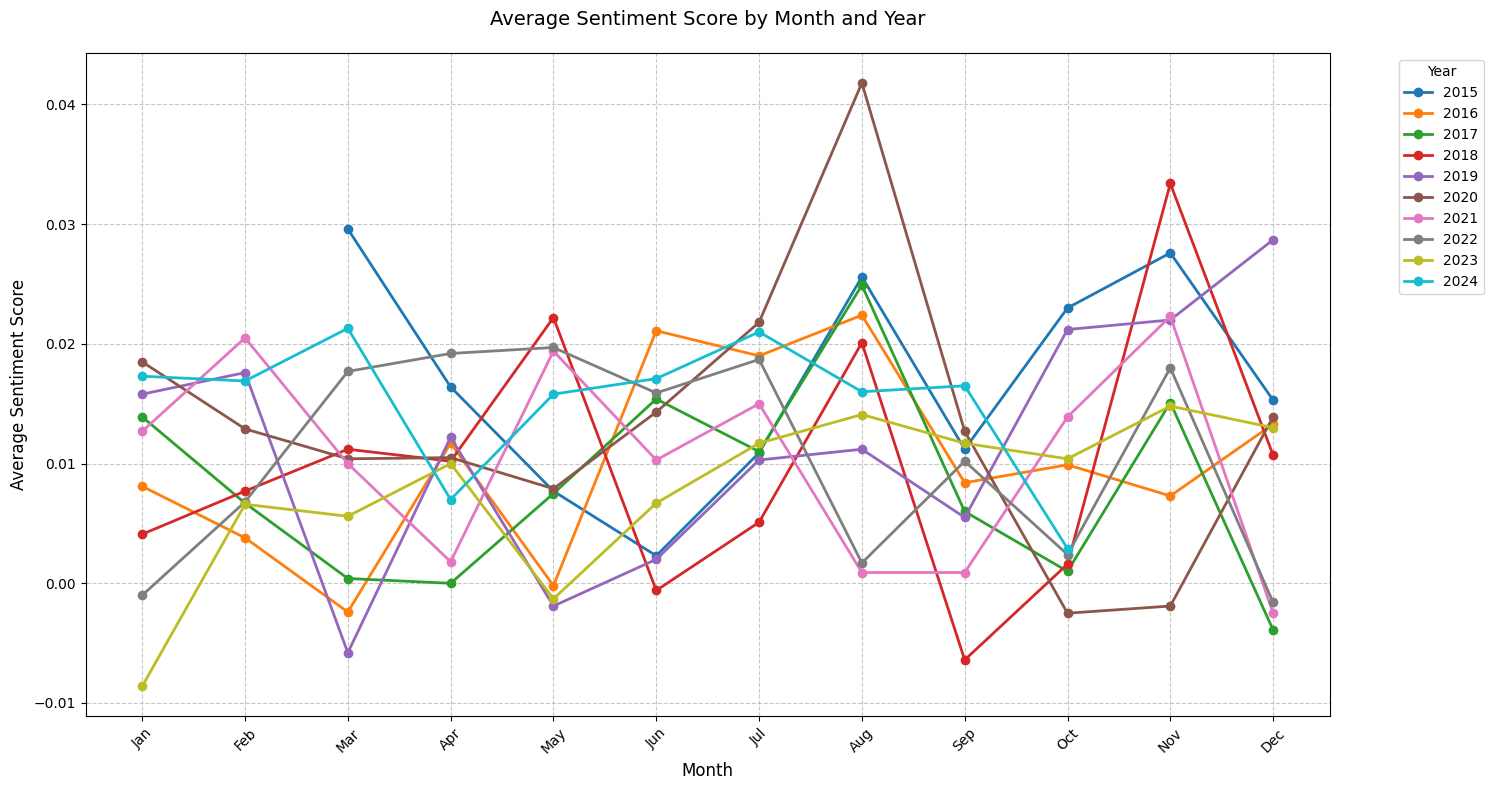

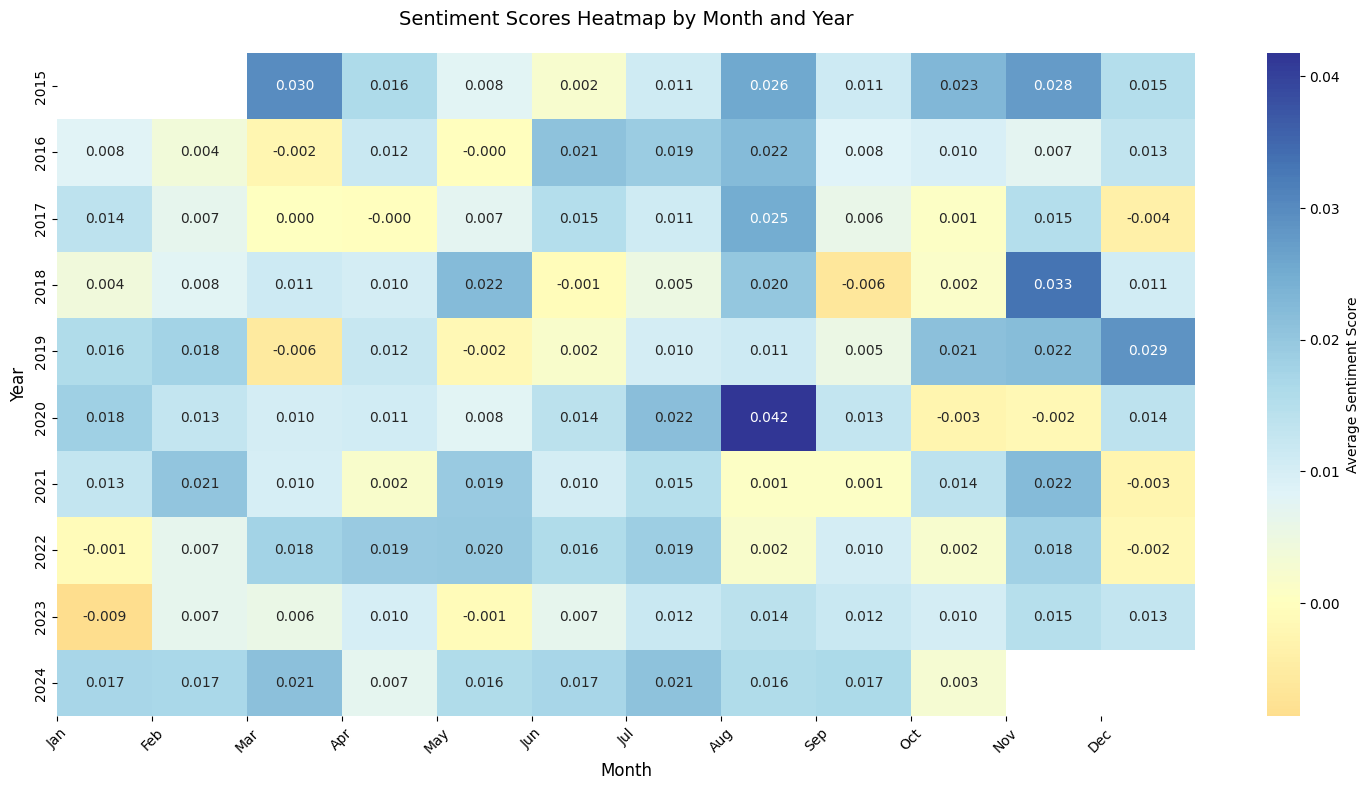

In [ ]:
fig1, fig2 = plot_sentiment_analysis(monthly_sentiment)
plt.show()

In [ ]:
from matplotlib.ticker import MaxNLocator

def plot_sentiment_by_separate_years(monthly_sentiment_df):
    """
    Create separate subplot visualizations for each year's sentiment trends
    """
    # Prepare the data
    df_plot = monthly_sentiment_df.reset_index()
    df_plot[['year', 'month']] = df_plot['month'].str.split('-', expand=True)
    df_plot['month_num'] = df_plot['month'].astype(int)
    df_plot['year'] = df_plot['year'].astype(int)

    # Get unique years and calculate subplot layout
    years = sorted(df_plot['year'].unique())
    n_years = len(years)
    n_cols = 2  # Number of columns in the subplot grid
    n_rows = (n_years + 1) // 2  # Number of rows needed (rounded up)

    # Create figure and subplots
    fig = plt.figure(figsize=(15, 5*n_rows))

    # Month names for x-axis
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    # Plot each year
    for idx, year in enumerate(years):
        # Create subplot
        ax = plt.subplot(n_rows, n_cols, idx + 1)

        # Get data for this year
        year_data = df_plot[df_plot['year'] == year].copy()

        # Sort by month number
        year_data = year_data.sort_values('month_num')

        # Plot the line
        plt.plot(year_data['month_num'],
                year_data['avg_sentiment'],
                marker='o',
                linewidth=2,
                color='#1f77b4')

        # Add confidence interval if available
        if 'confidence_interval' in year_data.columns:
            plt.fill_between(year_data['month_num'],
                           year_data['avg_sentiment'] - year_data['confidence_interval'],
                           year_data['avg_sentiment'] + year_data['confidence_interval'],
                           alpha=0.2,
                           color='#1f77b4')

        # Customize subplot
        plt.title(f'Sentiment Trends - {year}', fontsize=12, pad=10)
        plt.grid(True, linestyle='--', alpha=0.7)

        # Set x-axis ticks to show all months
        plt.xticks(range(1, 13), month_names, rotation=45)

        # Set y-axis limits to be consistent across subplots
        all_sentiments = df_plot['avg_sentiment']
        plt.ylim(all_sentiments.min() - 0.1, all_sentiments.max() + 0.1)

        # Add number of complaints as text annotations
        for i, row in year_data.iterrows():
            plt.annotate(f'n={int(row["total_complaints"])}',
                        (row['month_num'], row['avg_sentiment']),
                        textcoords="offset points",
                        xytext=(0,10),
                        ha='center',
                        fontsize=8)

        # Only add ylabel for leftmost subplots
        if idx % n_cols == 0:
            plt.ylabel('Average Sentiment Score', fontsize=10)

        # Only add xlabel for bottom subplots
        if idx >= len(years) - n_cols:
            plt.xlabel('Month', fontsize=10)

    # Add overall title
    plt.suptitle('Monthly Sentiment Trends by Year', fontsize=14, y=1.02)

    # Adjust layout to prevent overlapping
    plt.tight_layout()

    return fig

# Add a function to get basic statistics for each year
def print_yearly_statistics(monthly_sentiment_df):
    """
    Print basic statistics for each year
    """
    df_stats = monthly_sentiment_df.reset_index()
    df_stats[['year', 'month']] = df_stats['month'].str.split('-', expand=True)

    yearly_stats = df_stats.groupby('year').agg({
        'avg_sentiment': ['mean', 'min', 'max', 'std'],
        'total_complaints': 'sum'
    }).round(4)

    yearly_stats.columns = ['Mean Sentiment', 'Min Sentiment',
                          'Max Sentiment', 'Std Deviation',
                          'Total Complaints']

    return yearly_stats

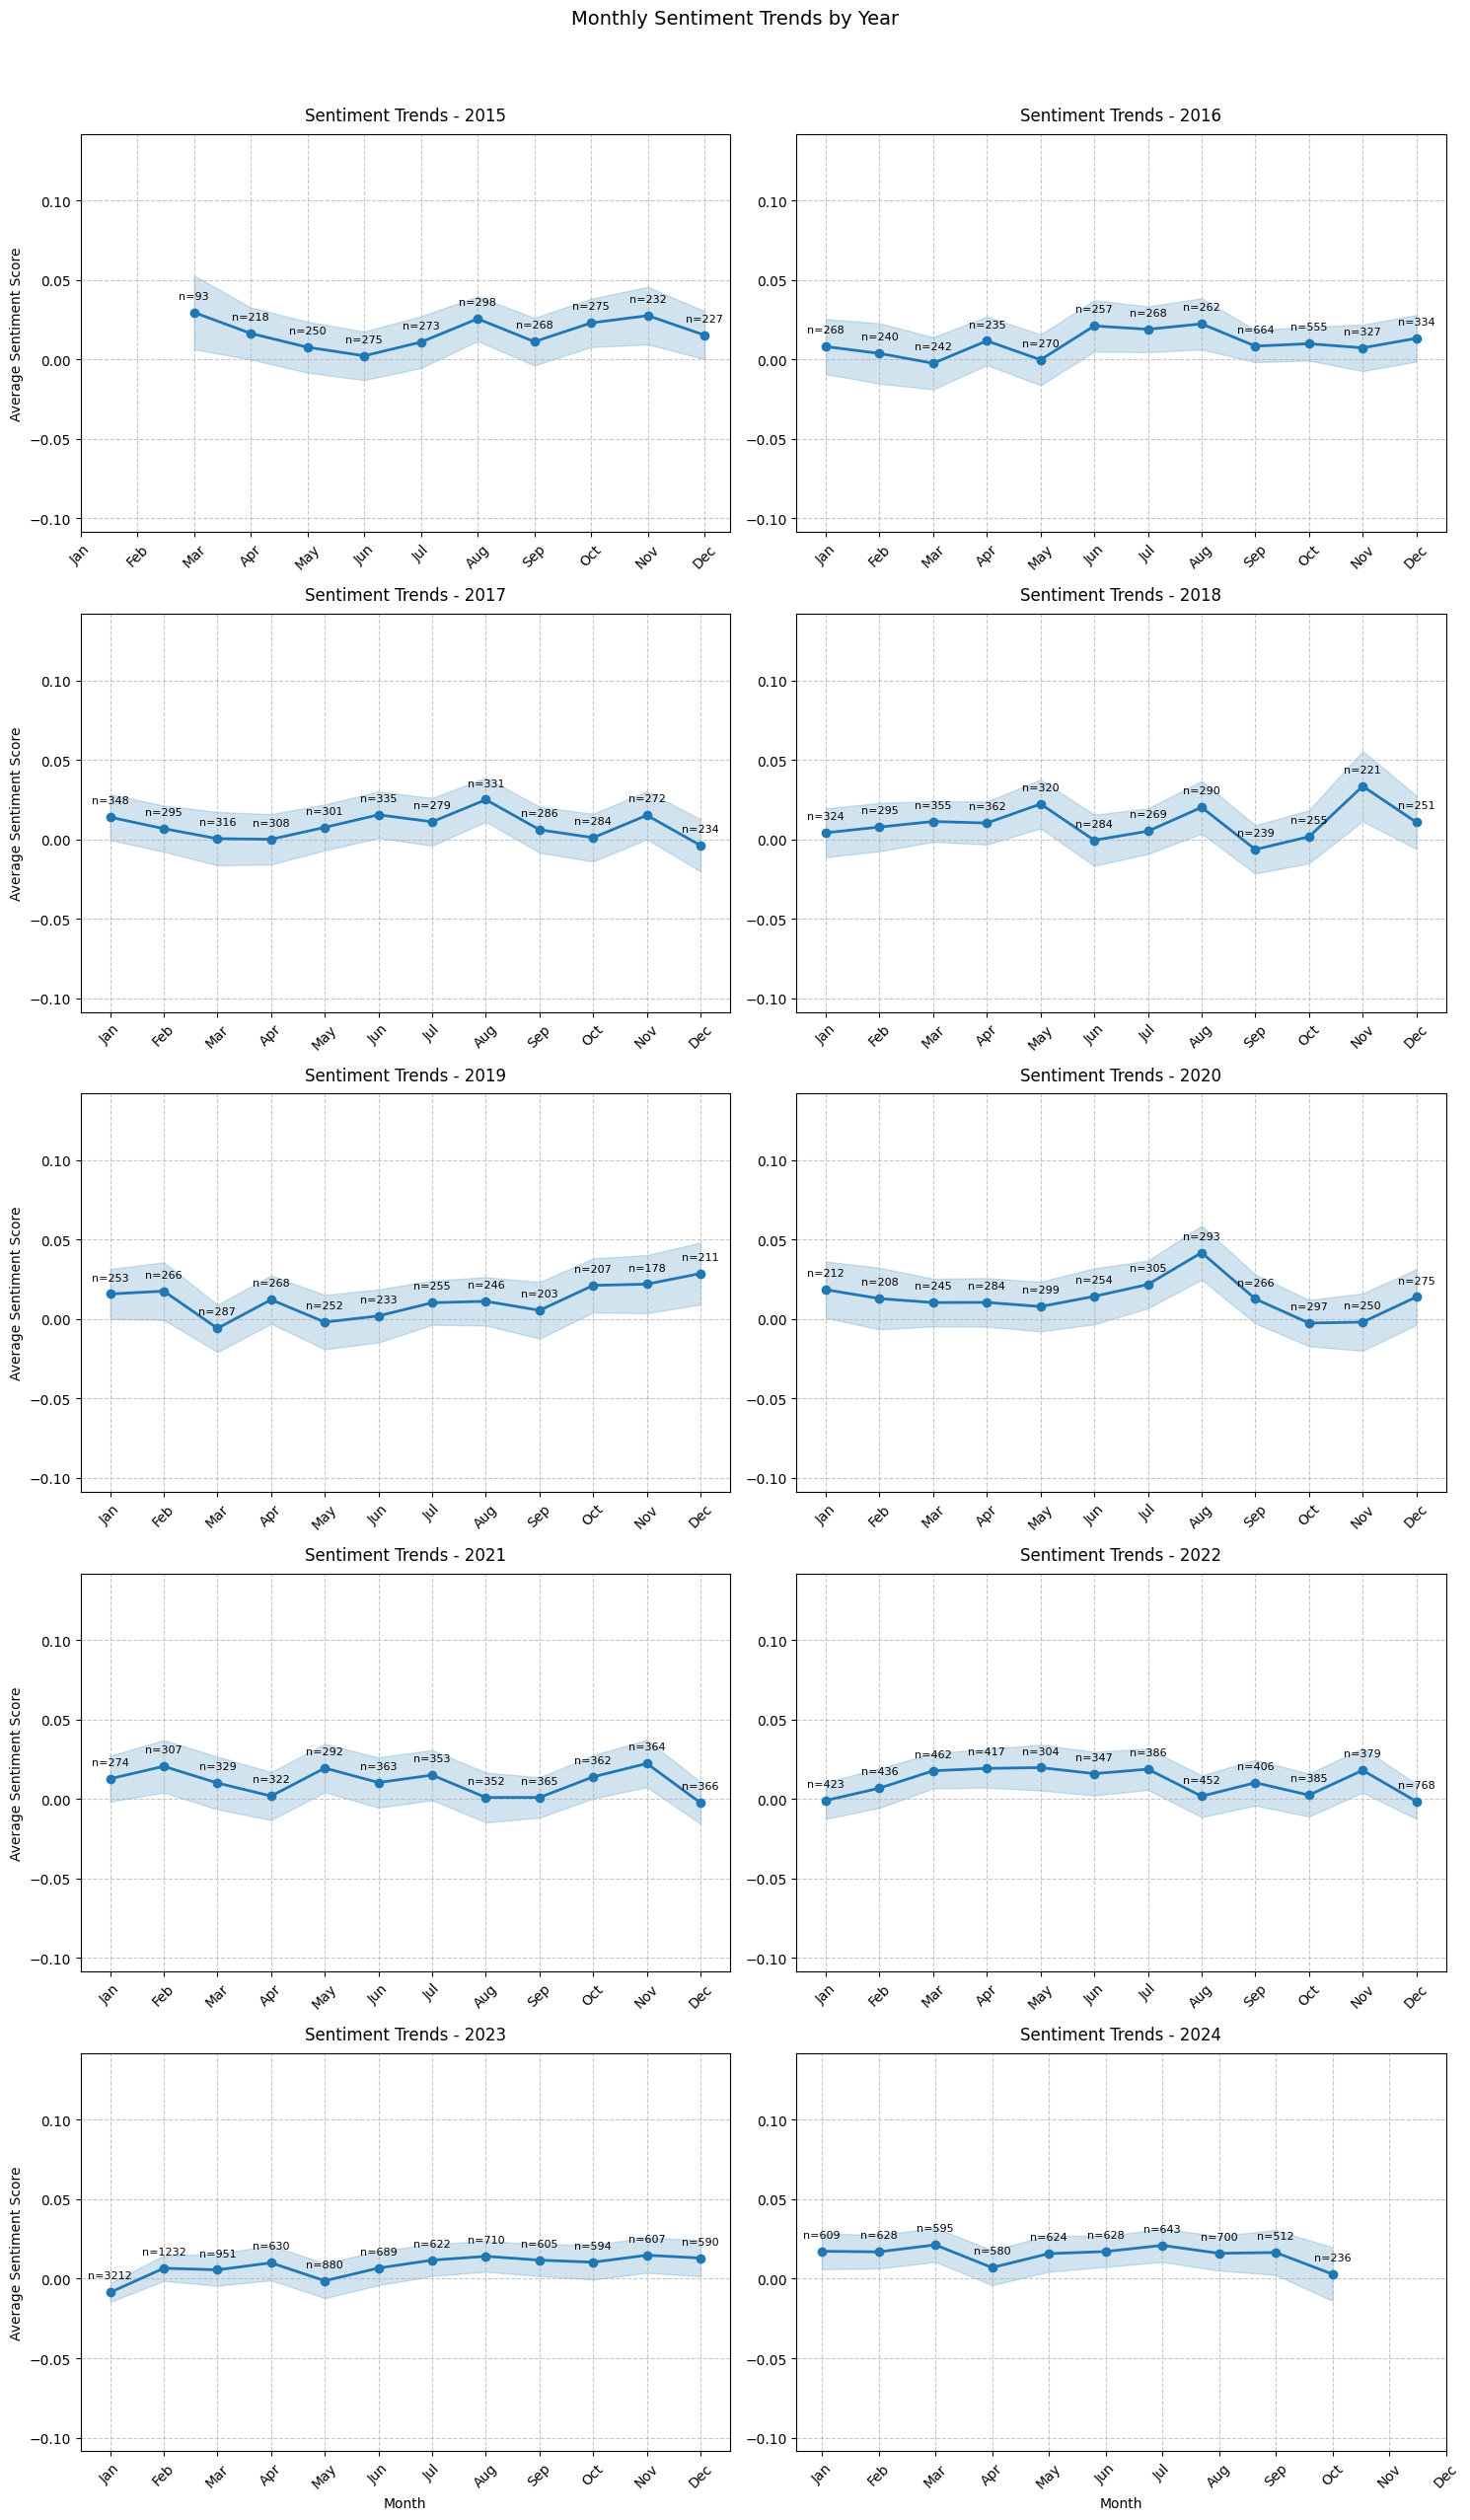

In [ ]:
fig = plot_sentiment_by_separate_years(monthly_sentiment)
plt.show()

In [ ]:
yearly_stats = print_yearly_statistics(monthly_sentiment)
print(yearly_stats)

      Mean Sentiment  Min Sentiment  Max Sentiment  Std Deviation  \
year                                                                
2015          0.0170         0.0023         0.0296         0.0092   
2016          0.0102        -0.0024         0.0224         0.0079   
2017          0.0082        -0.0039         0.0249         0.0083   
2018          0.0099        -0.0064         0.0334         0.0109   
2019          0.0116        -0.0058         0.0287         0.0103   
2020          0.0134        -0.0025         0.0418         0.0114   
2021          0.0104        -0.0025         0.0223         0.0084   
2022          0.0106        -0.0016         0.0197         0.0085   
2023          0.0079        -0.0086         0.0148         0.0069   
2024          0.0152         0.0029         0.0213         0.0058   

      Total Complaints  
year                    
2015              2409  
2016              3922  
2017              3589  
2018              3465  
2019              285